In [12]:
%matplotlib inline

In [236]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

import warnings

warnings.simplefilter('ignore')

In [180]:
dat = xr.open_mfdataset('combinations_lt_10_*.nc',concat_dim='clusters',)

/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0, '')

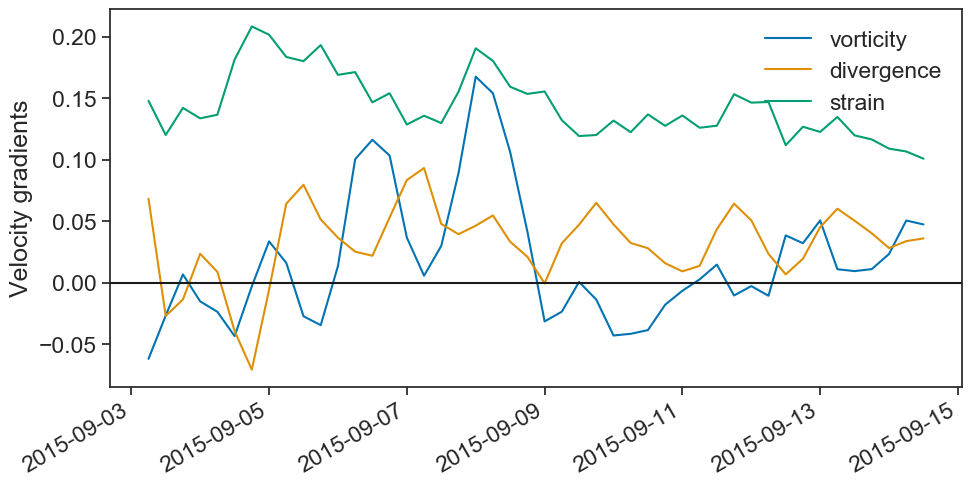

In [217]:
periods=3
dat.vort.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='vorticity')
dat.div.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='divergence')
dat.strain.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='strain')

# dat.vort.mean(axis=0).plot(label='vorticity')
# dat.div.mean(axis=0).plot(label='divergence')
# dat.strain.mean(axis=0).plot(label='strain')
plt.legend()
plt.axhline(0,color='k')
plt.ylabel('Velocity gradients')
plt.xlabel(None)

(1e-08, 10.0)

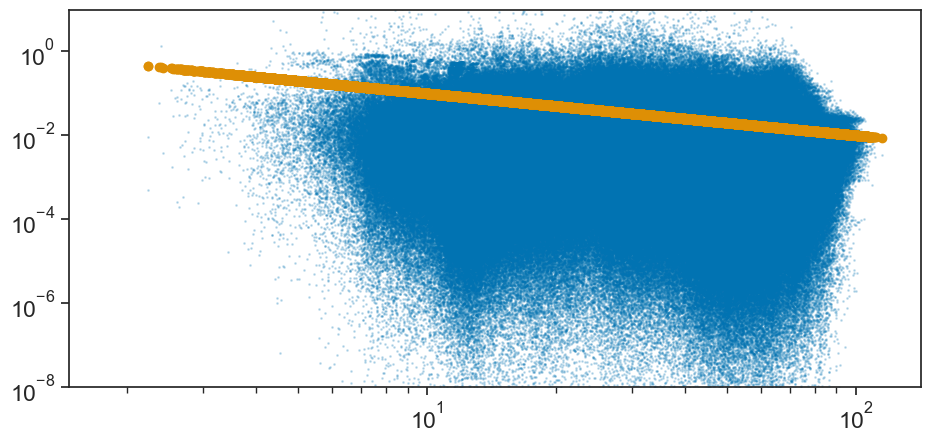

In [183]:
plt.scatter(dat.length,dat.vort**2,marker='o',s=1,alpha=0.2,rasterized=True)
plt.scatter(dat.length,dat.length**-1)
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-8,1e1)

In [184]:
dat['absvort'] = np.sqrt( dat.vort**2 )
dat['absdiv'] = np.sqrt( dat.div**2 )

In [202]:
grouped = dat.groupby_bins(dat.length,np.logspace(0,2,60)).mean()

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


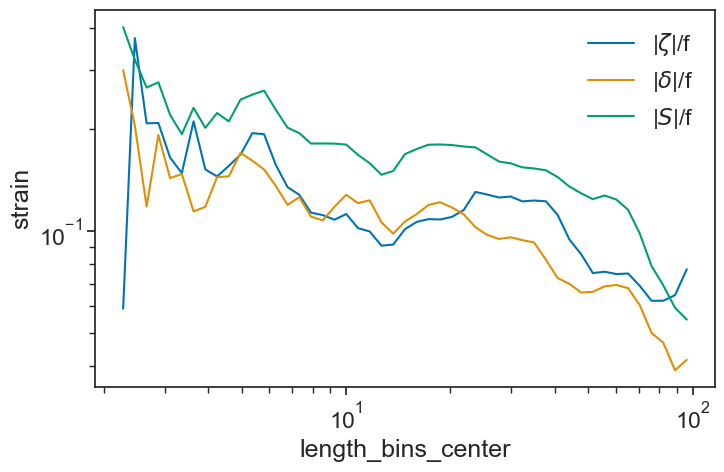

In [203]:
plt.figure(figsize=(8,5))
grouped.absvort.plot(label=r'|$\zeta$|/f')
grouped.absdiv.plot(label=r'|$\delta$|/f')
grouped.strain.plot(label=r'|$S$|/f')
# plt.plot(np.linspace(4,15),(np.linspace(4,15))**-1, color='k', lw=1)
# plt.plot(np.linspace(15,80),(0.2*np.linspace(15,80))**-1, color='k',lw=1)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [355]:
datm = dat.mean(dim='id')

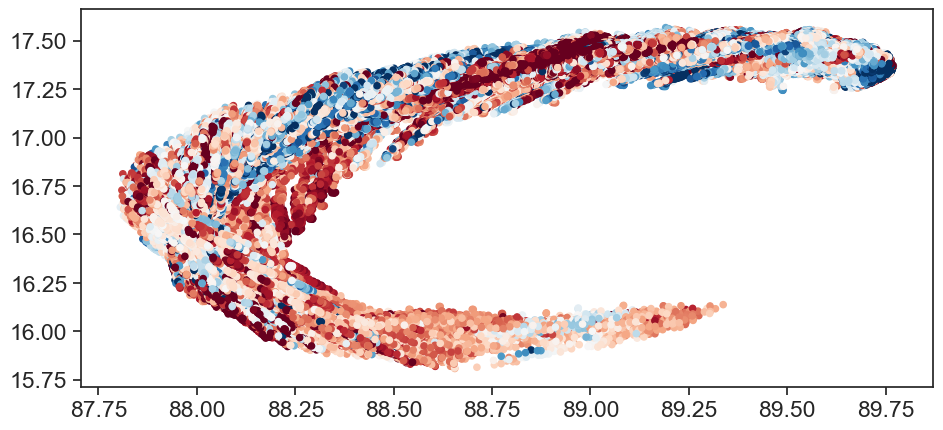

In [248]:
cl = 1
plt.scatter(datm.lon, datm.lat,1,
            datm.vort,vmin=-0.2,vmax=0.2, cmap='RdBu_r', rasterized=True);

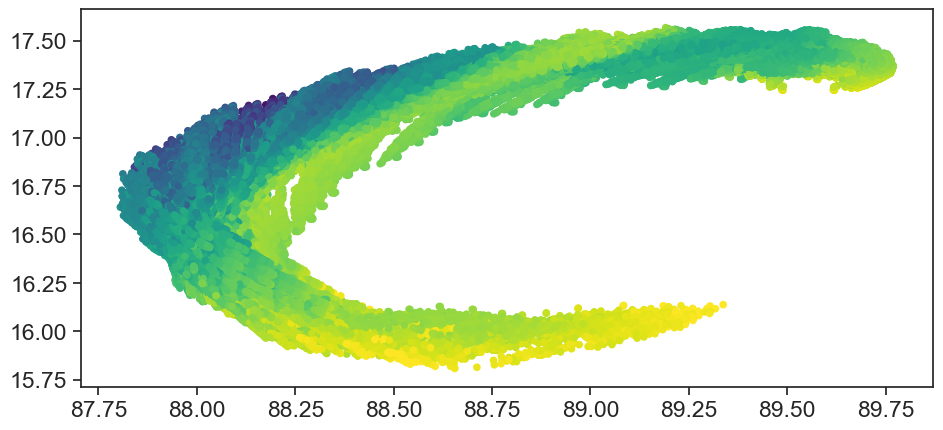

In [249]:
plt.scatter(datm.lon, datm.lat,1,
            datm.sal,vmin=27,vmax=31, cmap='viridis',rasterized=True);

In [260]:
from scipy.interpolate import griddata

In [328]:
xi = np.linspace(87.75,89.5, 100)
yi = np.linspace(15.75,17.5, 100)

In [368]:
datm = datm.sel(time=slice('2015-09-07','2015-09-12'))

In [369]:
lon = datm.lon.values.flatten()
lat = datm.lat.values.flatten()
sal = datm.sal.values.flatten()

mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(sal)
lon = lon[mask]
lat = lat[mask]
sal = sal[mask]

In [370]:
zsal = griddata((lon, lat), sal, (xi[None,:], yi[:,None]), method='linear' )

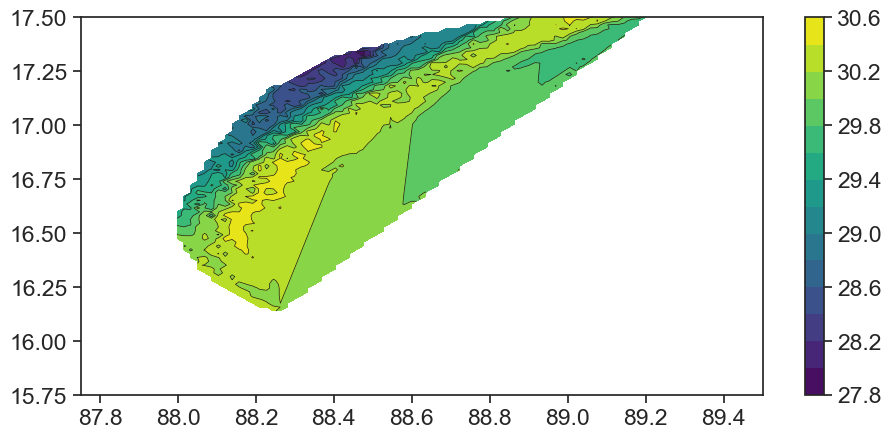

In [371]:
CS = plt.contour(xi,yi,zsal,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zsal,15,cmap='viridis')
plt.colorbar() # draw colorbar

In [372]:
lon = datm.lon.values.flatten()
lat = datm.lat.values.flatten()
vort = datm.vort.values.flatten()

mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(vort)
lon = lon[mask]
lat = lat[mask]
vort = vort[mask]

In [373]:
zi = griddata((lon, lat), vort, (xi[None,:], yi[:,None]), method='linear' )

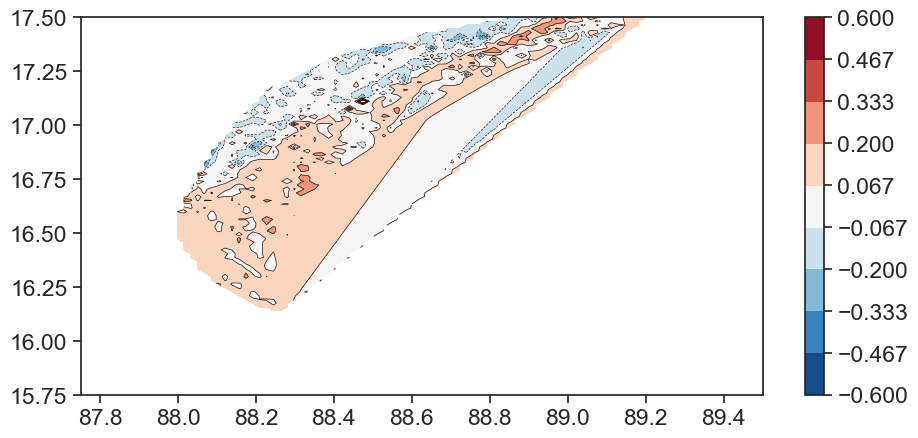

In [374]:
levels = np.linspace(-0.6,0.6,10)
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k',levels=levels)
CS = plt.contourf(xi,yi,zi,15, levels=levels, cmap='RdBu_r')
plt.colorbar() # draw colorbar

In [375]:
lon = datm.lon.values.flatten()
lat = datm.lat.values.flatten()
strain = datm.strain.values.flatten()

mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(strain)
lon = lon[mask]
lat = lat[mask]
strain = strain[mask]

In [ ]:
zstrain = griddata((lon, lat), strain, (xi[None,:], yi[:,None]), method='linear' )

In [ ]:
levels = np.linspace(0,0.5,10)
CS = plt.contour(xi,yi,zstrain,15,linewidths=0.5,colors='k', levels=levels)
CS = plt.contourf(xi,yi,zstrain,15, levels=levels, cmap='RdBu_r')
plt.colorbar() # draw colorbar

In [ ]:
lon = datm.lon.values.flatten()
lat = datm.lat.values.flatten()
div = datm.div.values.flatten()

mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(div)
lon = lon[mask]
lat = lat[mask]
div = div[mask]

zdiv = griddata((lon, lat), div, (xi[None,:], yi[:,None]), method='linear' )

In [ ]:
levels = np.linspace(-0.6,0.6,10)
CS = plt.contour(xi,yi,zdiv,15,linewidths=0.5,colors='k',levels=levels)
CS = plt.contourf(xi,yi,zdiv,15, levels=levels, cmap='RdBu_r')
plt.colorbar() # draw colorbar